Notebook to develop calculations for barotropic to baroclinic conversion.

$ C = <p'(-H) \vec{U}\cdot\nabla H>$

where $p'$ is pressure perturbation, $\vec{U}$ is barotropic velocity, $H$ is bottom topography. So bottom depth is z = -H(x,y)

$ p' = \int_z^0 N^2\zeta dz' - \frac{1}{H} \int_{-H}^0 \int_z^0 N^2\zeta dz' dz$

and $\zeta$ is isopycncal displacement. $<>$ denote an average over a tidal period. See Carter et al (2008), Energetics of M2 Barotropic to Baroclinic Tidal Conversion at the Hawaiian Islands

Alternatively, Kelly et al 2010 Internal‐tide energy over topography, defines

$ p' = p(x,z) - P(x)$

where $p(x,z)$ is the total pressure and $P(x)$ is the depth-averaged pressure.

$P(x) = \frac{1}{H}\int_{-H}^0 p(x,z)dz $

This is bizarre to me because were it the time dependency? I guess, in the model, the depth levels are actually changing with time, so both $z$ and $dz$ are time dependent. 

I will grab the pressure from the hydrostativ relation
$\frac{dp}{dz} = -\rho g$.
Then the time-dependency comes from the density.

I will use the Kelly et al 2010 apporach. Note, Kelly warns of using $C_S$ as a correction in shallow areas.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

from nowcast import analyze
from salishsea_tools import viz_tools, psu_tools, grid_tools


%matplotlib inline

In [2]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

bathy = grid.variables['Bathymetry'][:]

# 1. Calculate bathymetry gradient

In [3]:
def bathymetry_gradient(bathy, mesh):
    e1u = mesh.variables['e1u'][0,:,:]
    e2v = mesh.variables['e2v'][0,:,:]
    
    diff_x = bathy[:,1:] - bathy[:,:-1]
    diff_y = bathy[1:,:] - bathy[:-1,:]
    diff_x = np.concatenate([ diff_x, np.zeros((bathy.shape[0], 1))], axis=1) #pad with zeros in first row
    diff_y = np.concatenate([ diff_y, np.zeros((1, bathy.shape[1]))], axis=0) # pad with zeros in first column
    
    hx = diff_x/e1u
    hy = diff_y/e2v
    
    return hx, hy

In [4]:
hx, hy = bathymetry_gradient(bathy, mesh_mask)

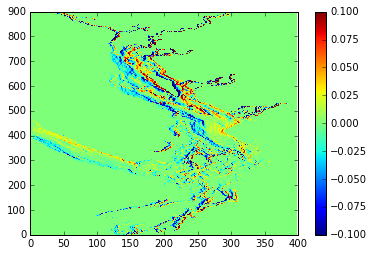

In [5]:
plt.pcolormesh(-hx,vmin=-.1,vmax=.1)
plt.colorbar()

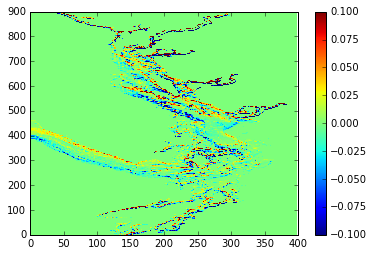

In [6]:
plt.pcolormesh(-hy,vmin=-.1,vmax=.1)
plt.colorbar()

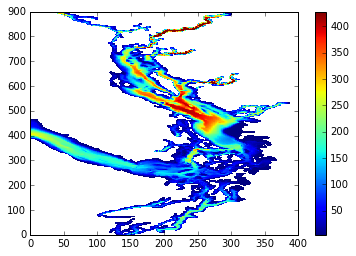

In [7]:
plt.pcolormesh(bathy)
plt.colorbar()

Check that barortopic w makes sense

In [8]:
fU = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_U.nc')
fV = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_V.nc')
fT = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_T.nc')
u = fU.variables['vozocrtx'][:]
v = fV.variables['vomecrty'][:]
ssh = fT.variables['sossheig']
umask = mesh_mask.variables['umask'][:] + np.zeros(u.shape)
vmask = mesh_mask.variables['vmask'][:] + np.zeros(v.shape)
tmask = mesh_mask.variables['tmask'][:]
e3t_0 = mesh_mask.variables['e3t'][:]
e3u_0 = mesh_mask.variables['e3u'][:]
e3v_0 = mesh_mask.variables['e3v'][:]
gdept_0 = mesh_mask.variables['gdept'][:]
gdepw_0 = mesh_mask.variables['gdepw'][:]

e2t = mesh_mask.variables['e2t'][0,:,:]
e2u = mesh_mask.variables['e2u'][0,:,:]
e2v = mesh_mask.variables['e2v'][0,:,:]

e1t = mesh_mask.variables['e1t'][0,:,:]
e1u = mesh_mask.variables['e1u'][0,:,:]
e1v = mesh_mask.variables['e1v'][0,:,:]

In [9]:
grids_u = grid_tools.time_dependent_grid_U(e3u_0[0,...], e1u, e2u, e1t, e2t, umask[0,:,:,:],
                                          ssh[:], {'e3u_0': e3u_0})
grids_v =  grid_tools.time_dependent_grid_V(e3v_0[0,...], e1v, e2v, e1t, e2t, vmask[0,:,:,:],
                                            ssh[:], {'e3v_0': e3v_0})

In [10]:
def depth_average(var, grid, mask):
    integral = np.sum(var*grid*mask, axis=1)
    H = np.sum(grid*mask,axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        one_over_H = 1 / H
    one_over_H = np.nan_to_num(one_over_H)
    return integral*one_over_H

In [11]:
u_depav = depth_average(u,grids_u['e3u_t'], umask)
v_depav = depth_average(v,grids_v['e3v_t'], vmask)

udepav_m = np.ma.masked_array(u_depav, mask = 1-umask[:,0,:,:])
vdepav_m = np.ma.masked_array(v_depav, mask = 1-vmask[:,0,:,:])
udepav_s,vdepav_s = viz_tools.unstagger(udepav_m,vdepav_m)

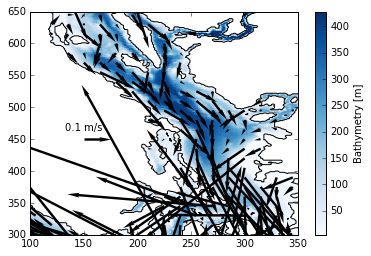

In [12]:
st=15
t=15
xx, yy = np.meshgrid(np.arange(v_depav.shape[-1]), np.arange(v_depav.shape[-2]))
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(bathy,cmap='Blues')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Bathymetry [m]')
q=ax.quiver(xx[::st,::st],yy[::st,::st],udepav_s[t,::st,::st],vdepav_s[t,::st,::st],scale=1,
            color='k',width=0.009,headwidth=2,)
ax.quiverkey(q,150,450,.1,'0.1 m/s', color='k',coordinates='data')
ax.set_xlim([100,350])
ax.set_ylim([300,650])
viz_tools.plot_coastline(ax,grid)

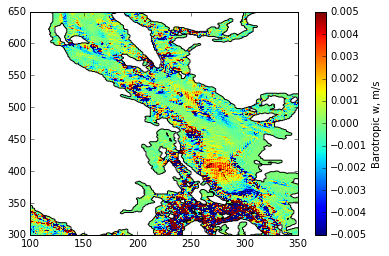

In [13]:
wB = -udepav_m*hx + -vdepav_m*hy
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(wB[t,:,:],vmin=-.005,vmax=.005)
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Barotropic w, m/s')
ax.set_xlim([100,350])
ax.set_ylim([300,650])
viz_tools.plot_coastline(ax,grid)
del u, v, udepav_s, vdepav_s, udepav_m, vdepav_m, u_depav, v_depav, e3u_0, e3v_0, umask, vmask
del grids_u, grids_v

* Between Gulf islands and Tsawwassen, depth averaged currents are mostly towards the south east (ignoring bounday pass). Topoography is getting shallower so we should have upward w, which we do.
* The barotropic vertical velocity is really noisy, especially in Boundary Pass where currents are large and bathymetry is complex and steep.  This is probably mostly because the bathymetry gradients are noisy. 


# 2. Calculating baroclinic pressure

See this notebook for how I developed these calculations: http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis-nancy/raw/tip/notebooks/energy_flux/Hydrostatic%20pressure%20-%20development.ipynb

All of this is written into a module pressure.py.

In [14]:
import pressure

In [15]:
input_vars = {'e3t_0': e3t_0,
              'gdept_0': gdept_0,}
grids = grid_tools.calculate_time_dependent_grid(e3t_0[0,...],tmask[0,...],ssh[:],input_vars)

In [16]:
sal = fT.variables['vosaline'][:]
temp = fT.variables['votemper'][:]
rho = psu_tools.calculate_density(temp, sal)
p = pressure.hydrostatic_pressure(rho, grids['e3t_t'], grids['gdept_t'], tmask)
p_it = pressure.internal_tide_pressure(p, grids['e3t_t'], tmask)

Bottom pressure

In [17]:
mbathy = mesh_mask.variables['mbathy'][0,:,:]

bottom_p = np.zeros(ssh.shape)
for j in np.arange(bottom_p.shape[-2]):
    for i in np.arange(bottom_p.shape[-1]):
        level=mbathy[j,i]
        bottom_p[:,j,i] = p_it[:,level, j, i]

# 3. Conversion $C_T$

In [18]:
CT = bottom_p*wB

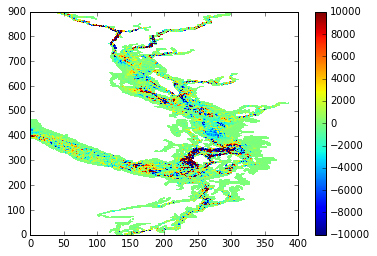

In [19]:
t=10
plt.pcolormesh(CT[t,...],vmin=-1*10**4,vmax=1*10**4)
plt.colorbar()
#plt.xlim([200,350])
#plt.ylim(200,500)

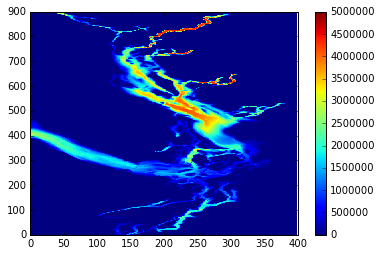

In [20]:
t=1
plt.pcolormesh(bottom_p[t,...],vmin=0,vmax=5*10**6)
plt.colorbar()

Mean

In [21]:
mean_CT = np.mean(CT,axis=0)

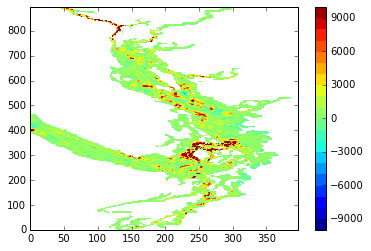

In [22]:
plt.contourf(mean_CT,np.arange(-1e4,1e4+1000,1000))
plt.colorbar()
#plt.xlim([100,350])
#plt.ylim(100,600)

I need a longer average. Am I going to have enough memory? I should probably use time dependent scale factors when calcualting depth averge u/v too.

# 4. Conversion $C_S$

$C_S = -\eta_t p'|_{z=0}$ (Kelly et al 2010)

In [23]:
fW = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_W.nc')
w = fW.variables['vovecrtz'][:]
CS = -w[:,0,:,:]*p_it[:,0,:,:]

In [24]:
mean_CS = np.mean(CS,axis=0)

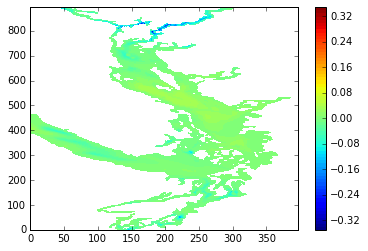

In [25]:
plt.contourf(mean_CS,np.arange(-.35,.36,.01))
plt.colorbar()

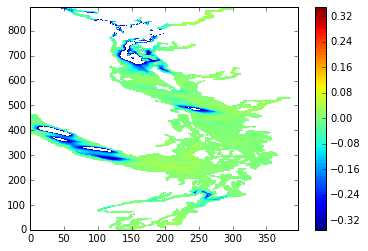

In [26]:
plt.contourf(CS[0,:,:],np.arange(-.35,.36,.01))
plt.colorbar()